In [1]:
#!/usr/bin/env python3
# This script pulls in data, builds and tests several predictive models,and then makes predictions on test data using the best model.'''

__author__ = "Vusal Babashov"
__email__ = "vbabashov@gmail.com"
__website__ = 'https://vbabashov.github.io'


import pandas as pd
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sqlite3
from sqlite3 import Error

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from feature_engine import encoding as enc #RareLabelEncoder, OrdinalEncoder
from feature_engine.selection import SelectByTargetMeanPerformance, DropFeatures 
from feature_engine.creation import CombineWithReferenceFeature, MathematicalCombination


class Data:
    '''create train and test dataframe'''
    def __init__(self, train_file, test_file, nom_cols, ord_cols, ordinal_categories_list, num_cols, target_col):
        #create new copies instead of references
        self.nom_cols = list(nom_cols)
        self.ord_cols = list(ord_cols)
        self.num_cols = list(num_cols)
        self.target_col = target_col
        self.ord_cat_list = list(ordinal_categories_list)
        self.cat_cols = self.nom_cols + self.ord_cols
        self.feature_cols = self.cat_cols + self.num_cols + self.ord_cols
        self.cols_to_drop =[]
        self.ordinal_encoders = {}
        self.train_df = self._create_train_df(train_file)
        self.test_df  = self._create_test_df(test_file)
        self.encoder = None


    def _load_data(self,file):
        '''loads csv to pd dataframe'''
        return pd.read_csv(file)


    def _log_transform (self, df):
        '''This function performs the log transformation of the target'''
        df['SalePrice'] = np.log(df['SalePrice'])
        return df


    def _drop_missing_cols (self,df):
        '''Identifies and drops the columns with 80% or hihgher proportion of missing data '''
        dropped_cols = []  
        for col in df.columns:
            if df[col].isnull().sum()/df.shape[0] >= 0.8:
                dropped_cols.append(col)
        df.drop(columns=dropped_cols, inplace=True)
        return df, dropped_cols 


    def _impute_missing_values (self, df, categorical_features, numeric_features):
        ''' Imputes the continious columns with median and categorical columns with the mode value'''
        imputer_con = SimpleImputer(missing_values=np.nan, strategy='median')
        imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        for col in categorical_features+numeric_features:
            if df[col].isnull().sum() > 0:    
                if col in categorical_features:              
                    df[col] = imputer_cat.fit_transform(df[col].values.reshape(-1,1))
                elif col in numeric_features:  
                    df[col] = imputer_con.fit_transform(df[col].values.reshape(-1,1))
        return df 


    def _ordinal_encode (self, df, ord_cols, ordinal_categories_list):
        '''This function encodes ordinal variables into ordinal encoding and combines wit the rest of the dataframe'''
        encoder = OrdinalEncoder(categories=ordinal_categories_list)
        df[ord_cols] = encoder.fit_transform(df[ord_cols])
        return df
    
    
    def _inverse_ordinal_encode (self, df, ord_cols):
         df[ord_cols] = self.encoder.inverse_transform(df[ord_cols]) 
          
    
    def _create_train_df(self, train_file, preprocess=True):
        '''loads and encodes train data'''
        train_df = self._load_data(train_file)
        if preprocess:
            train_df = self._log_transform(train_df)
            train_df, self.cols_to_drop = self._drop_missing_cols(train_df)
            train_df = self._impute_missing_values(train_df, self.cat_cols, self.num_cols)
            train_df = self._convert_month_string(train_df)
            train_df = self._ordinal_encode(train_df, self.ord_cols, self.ord_cat_list)
            train_df = self._convert_data_types(train_df)
        return train_df

    
    def _create_test_df (self,test_file, preprocess=True):
        '''loads and ordinal encodes test data'''
        test_df = self._load_data(test_file)
        if preprocess:
            test_df = test_df.drop(columns=self.cols_to_drop, axis=1)
            test_df = self._impute_missing_values(test_df, self.cat_cols, self.num_cols)
            test_df = self._convert_month_string(test_df)
            test_df = self._ordinal_encode(test_df, self.ord_cols, self.ord_cat_list) 
            test_df = self._convert_data_types(test_df)
        return test_df
           

    def _convert_month_string (self, df):
        '''This function maps the numerical month names into string month names'''
        d = { 1 : 'Jan',
              2 : 'Feb',
              3 : 'Mar',
              4 : 'Apr',
              5 : 'May',
              6 : 'June',
              7 : 'July',
              8 : 'Aug',
              9 : 'Sep',
              10: 'Oct',
              11: 'Nov',
              12: 'Dec'
        }
        df['MoSold'] = df ['MoSold'].map(d)
        return df


    def _convert_data_types (self, df):
        '''This function coverts the categorical variables into object and numeric variables into int types'''
        df[self.nom_cols] = df[self.nom_cols].astype('O')
        df[self.ord_cols] = df[self.ord_cols].astype('int')
        df[self.num_cols] = df[self.num_cols].astype('int') 
        return df

In [2]:
class FeatureGenerator:
    
    def __init__(self, data):
        '''creates feature generator pipeline'''
        self.data = data
        self.cat_cols = data.cat_cols
        self.pipeline = None
    
    def create_pipeline (self, features, target):
        ''' Creates engineer various features using pipeline'''
        rare_encoder = enc.RareLabelEncoder(tol = 0.05, n_categories=4, variables = data.nom_cols)
        price_encoder = enc.OrdinalEncoder (encoding_method='ordered',  variables = data.nom_cols)

        age = CombineWithReferenceFeature(
            variables_to_combine=['YrSold'],
            reference_variables=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'],
            operations = ['sub']
        )     

        bath = MathematicalCombination(
            variables_to_combine=['BsmtHalfBath', 'BsmtFullBath', 'FullBath', 'HalfBath'],
            math_operations=['sum'],
            new_variables_names=['TotalBath'],
        )

        area = MathematicalCombination(
            variables_to_combine=['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF'],
            math_operations=['sum'],
            new_variables_names=['TotalArea'],
        )

        drop = DropFeatures(
            features_to_drop=['YearBuilt','YrSold','YearRemodAdd', 'GarageYrBlt']
        )

        pipe = Pipeline(steps=[ 
                                ('rare_encoder', rare_encoder), 
                                ('ordinal_encoder', price_encoder),
                                ('cobinator',age),
                                ('bath', bath),
                                ('area', area),
                                ('drop', drop)
                            ])
        self.pipeline = pipe.fit(features, target)  
    
    def create_features(self,df):        
        '''Transform data and Generate Features'''
        df = self.pipeline.transform (df)
        return df
        

In [3]:
class ModelContainer:
    
    def __init__(self):
        '''initializes model list and dicts'''
        self.best_algorithm  = None
        self.gridcvs = {}
        self.scores_dict = None
        self.best_model = None
        self.best_params  = None
        self.best_score  = 0
        self.predictions = None
        self.train_mae = 0
        self.test_mae  = 0
        self.train_r2  = 0
        self.test_r2   = 0
        self.mean_rmse = {}
        self.parameters = {}
    
        
    def nested_cross_validation(self, features, target):
        '''This function performs the nested 5x2cv procedure and selects best algorithm'''    
        reg1 = RandomForestRegressor(random_state=1)
        reg2 = XGBRegressor(random_state=1)
        reg3 = LGBMRegressor(random_state=1)   
                   
        param_grid1 = {'n_estimators': [500,1000]}
        
        param_grid2 = { 'colsample_bytree':[0.6, 0.8], 
                         'max_depth': [8,10],
                         'min_child_weight':[3,7], 
                         'regsubsample' :[0.6, 0.8]}
        
        param_grid3 = {'num_leaves': [6, 8, 20, 30],
                        'max_depth': [2, 4, 6, 8, 10],
                        'n_estimators': [50, 100, 200, 500],
                        'colsample_bytree': [0.3, 1.0]}

        
        self.parameters= {reg1:param_grid1, reg2:param_grid2, reg3:param_grid3}
        
    
        inner_cv = KFold(n_splits=2, shuffle=True, random_state=1)

        for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3),
                                    (reg1, reg2, reg3),
                                    ('RForest','Xgboost', 'LightGBM')):

            gcv = GridSearchCV(estimator=est,
                               param_grid=pgrid,
                               scoring = 'neg_root_mean_squared_error',
                               n_jobs=-1,
                               cv=inner_cv,
                               verbose=0,
                               refit=True)
            self.gridcvs[name] = gcv


        outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
    
        for name, gs_est in sorted(self.gridcvs.items()):
            self.scores_dict = cross_validate(gs_est, 
                                         X=features, 
                                         y=target,
                                         verbose=0,
                                         cv=outer_cv,
                                         return_estimator=True,
                                         n_jobs=-1
                                        )

            print(50 * '-', '\n')
            print('Algorithm:', name)
            print('    Inner loop:')


            for i in range(self.scores_dict['test_score'].shape[0]):
                print('\n      Best RMSE Score (avg. of inner test folds) %.2f' % np.absolute(self.scores_dict['estimator'][i].best_score_))
                print('        Best parameters:', self.scores_dict['estimator'][i].best_estimator_)
                print('        RMSE Score (on outer test fold) %.2f' % np.absolute(self.scores_dict['test_score'][i]))
            print('\n%s |  outer test folds Ave. Score %.2f +/- %.2f' % 
                                  (name, np.absolute(self.scores_dict['test_score']).mean(), 
                                   np.absolute(self.scores_dict['test_score']).std()))    
            
            self.mean_rmse[gs_est] = np.absolute(self.scores_dict['test_score']).mean() 
            
        self.best_algorithm = min(self.mean_rmse, key=self.mean_rmse.get)
        print ('\nBest Performing Algorithm: ', self.best_algorithm.estimator)
    

   
    def tune_best_algorithm (self, feature_train, feature_test, target_train, target_test): 
        '''This function performs hyperparameter tuning on the whole training set with the best algorithm '''
        gcv_model_select = GridSearchCV(estimator=self.best_algorithm.estimator,
                                        param_grid=self.parameters[self.best_algorithm.estimator],
                                        scoring='neg_root_mean_squared_error',
                                        n_jobs=-1,
                                        cv = 2,
                                        verbose=0,
                                        refit=True)

        gcv_model_select.fit(feature_train, target_train)
            
        self.best_model = gcv_model_select.best_estimator_
        self.best_score = gcv_model_select.best_score_
        self.best_params = gcv_model_select.best_params_
            
        self.train_mae = mean_absolute_error(y_true=np.exp(target_train), y_pred=np.exp(self.best_model.predict(feature_train)))
        self.test_mae  = mean_absolute_error(y_true=np.exp(target_test),  y_pred=np.exp(self.best_model.predict(feature_test)))

        self.train_r2 = r2_score (y_true=np.exp(target_train), y_pred=np.exp(self.best_model.predict(feature_train)))
        self.test_r2  = r2_score (y_true=np.exp(target_test),  y_pred=np.exp(self.best_model.predict(feature_test)))

   

    def best_model_predict(self, features):
        '''scores features using best model'''
        self.predictions = self.best_model.predict(features)
       
    
    def save_results(self):
        pass 
    
        
    @staticmethod
    def get_feature_importance(model, cols):
        '''retrieves and sorts feature importances'''
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            cols = model.feature_name_
            feature_importances = pd.DataFrame({'feature':cols, 'importance':importances})
            feature_importances.sort_values(by='importance', ascending=False, inplace=True)
            #set index to 'feature'
            feature_importances.set_index('feature', inplace=True, drop=True)
            return feature_importances
        else:
            #some models don't have feature_importances_
            return "Feature importances do not exist for given model"

        
    def print_summary(self):
        '''prints summary of models, best model, and feature importance'''
        print('\nModel Summaries:\n')
        
        print('Best Estimator:' ,self.best_model)
        print('Best CV Score: %.2f' % np.abs(self.best_score))
        print('Best Parameters: %s' % self.best_params)
        
        print('\nTrain MAE: %.2f' % self.train_mae)
        print(' Test MAE: %.2f' %  self.test_mae)

        print('\nTrain R2: %.2f' % self.train_r2)
        print(' Test R2: %.2f' %   self.test_r2)
            
        feature_importances = self.get_feature_importance(self.best_model, data.feature_cols)
        feature_importances[0:25].plot.bar(figsize=(20,10))
        plt.show()
    
    
    
    def save_to_database (self):
        connection = None
        try:
            conn = sqlite3.connect("/Users/vusalbabashov/Desktop/house-prices/reports/prediction.sqlite")
        except Error as e:
            print(f"The error '{e}' occurred")
        cur = conn.cursor()
        pd.DataFrame(self.predictions, columns = ['Log Predictions']).to_sql("pred", conn, index=False, if_exists = 'replace')
        
       
    
    
    def read_from_database (self):
        df = pd.read_sql_query("select * from pred;", sqlite3.connect("/Users/vusalbabashov/Desktop/house-prices/reports/prediction.sqlite"))
        return df.head()

   


-------------------------------------------------- 

Algorithm: LightGBM
    Inner loop:

      Best RMSE Score (avg. of inner test folds) 0.13
        Best parameters: LGBMRegressor(colsample_bytree=0.3, max_depth=6, num_leaves=6, random_state=1)
        RMSE Score (on outer test fold) 0.12

      Best RMSE Score (avg. of inner test folds) 0.13
        Best parameters: LGBMRegressor(max_depth=2, n_estimators=500, num_leaves=6, random_state=1)
        RMSE Score (on outer test fold) 0.16

      Best RMSE Score (avg. of inner test folds) 0.14
        Best parameters: LGBMRegressor(colsample_bytree=0.3, max_depth=6, num_leaves=20, random_state=1)
        RMSE Score (on outer test fold) 0.12

      Best RMSE Score (avg. of inner test folds) 0.13
        Best parameters: LGBMRegressor(colsample_bytree=0.3, max_depth=4, num_leaves=20, random_state=1)
        RMSE Score (on outer test fold) 0.13

      Best RMSE Score (avg. of inner test folds) 0.14
        Best parameters: LGBMRegressor(col

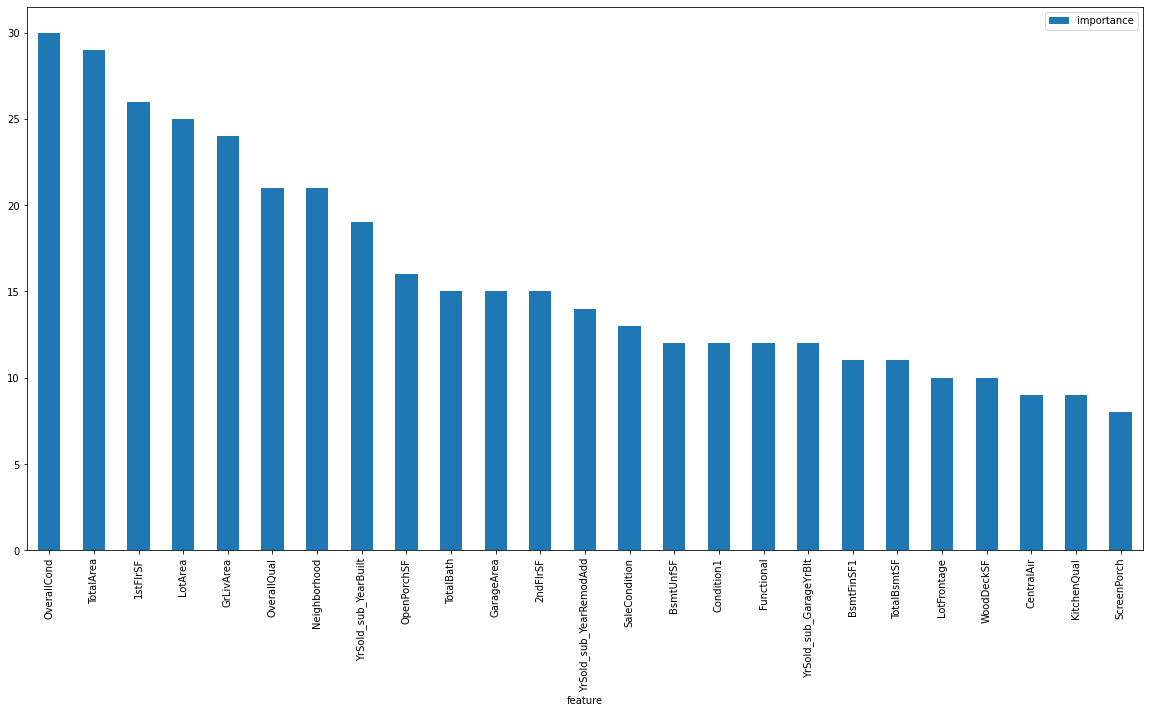

In [4]:
if __name__=='__main__':
    
    train_file = "/Users/vusalbabashov/Desktop/house-prices/data/raw/train.csv"
    test_file =  "/Users/vusalbabashov/Desktop/house-prices/data/raw/test.csv"
    
    
    nominal_cols = ['MSSubClass', 'MSZoning', 'Street', 'LandContour', 'LotConfig', 
                   'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                   'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                   'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MoSold',
                   'SaleType', 'SaleCondition'] # removed Alley, MiscFeature, 

    ordinal_cols = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 
                   'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                   'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 
                   'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
                   'PavedDrive'] #removed PoolQC, Fence,


    numeric_cols = ['Id','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
                  'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                  'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr', 'TotRmsAbvGrd',
                  'Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                   '3SsnPorch','ScreenPorch','PoolArea','MiscVal', 'GarageYrBlt', 'YrSold'] # removed the SalePrice

    
    target_col ='SalePrice'
    
    
    lot_shape = ['IR3','IR2','IR1','Reg']
    utilities = ['ELO', 'NoSeWa', 'NoSewr','AllPub']
    land_slope = ['Sev','Mod','Gtl']
    overall_qual = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  
    overall_cond = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  
    exter_qual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    exter_cond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    bsmt_qual  = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
    bsmt_cond  = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
    bsmt_exposure  = ['NA', 'No', 'Mn', 'Av', 'Gd']
    bsmt_fin_type1 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
    bsmt_fin_type2 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
    heating_qual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    electrical = ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr']
    kitchen_qual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    functional = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
    fire_place_qual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
    garage_finish = ['NA', 'Unf', 'RFn', 'Fin']
    garage_qual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
    garage_cond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
    paved_drive = ['N', 'P', 'Y']

    ordinal_cat_list = [lot_shape , utilities, land_slope, overall_qual, overall_cond, exter_qual, exter_cond, bsmt_qual, 
                              bsmt_cond, bsmt_exposure, bsmt_fin_type1, bsmt_fin_type2, heating_qual, electrical, kitchen_qual,
                              functional, fire_place_qual, garage_finish, garage_qual, garage_cond, paved_drive] 
    
    
    #turn feature engineering on/off
    engineer_features = True
    
    #Create Data object
    data = Data(train_file, test_file, nominal_cols, ordinal_cols, ordinal_cat_list, numeric_cols, target_col)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(data.train_df.drop(['Id', 'SalePrice'], axis=1),data.train_df['SalePrice'],
                                                             test_size=0.2,
                                                             random_state=0)

    X_features = data.test_df.drop(columns=['Id'], axis=1)
    
    
    #Engineer features
    if engineer_features:
        feature_generator = FeatureGenerator(data)
        feature_generator.create_pipeline(X_train, y_train)
        X_train = feature_generator.create_features(X_train)
        X_test  = feature_generator.create_features(X_test)
        X_features = feature_generator.create_features(X_features)
    
       
    #Create model container
    models = ModelContainer()
    models.nested_cross_validation(X_train, y_train)
    models.tune_best_algorithm(X_train, X_test, y_train, y_test)
    models.best_model_predict(X_features)
    models.print_summary()
    models.save_to_database()
    

In [5]:
models.read_from_database()

,Log Predictions
0,11.718402
1,12.011874
2,12.101743
3,12.158870
4,12.108312
